In [171]:
# numpy and pandas for data manipulation
import numpy as np
import pandas as pd 

# File system manangement
import os

# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')


# matplotlib and seaborn for plotting
import matplotlib.pyplot as plt
import seaborn as sns


In [172]:
df = pd.read_csv("../fin_health.csv")

In [173]:
from sklearn.model_selection import train_test_split


X = df.drop(columns=['ID', 'Target'])
y = df['Target']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

In [174]:
X_train_original = X_train.copy()
X_test_original = X_test.copy()

In [175]:
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
num_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [176]:
# Dictionary of replacements for multiple columns
replacements = {
    'has_loan_account': {
        "Used to have but don't have now": "Used to have but don’t have now"
    },
    'has_mobile_money': {
        "Used to have but don't have now": "Used to have but don’t have now"
    },
    'has_credit_card': {
        "Used to have but don't have now": "Used to have but don’t have now"
    },
    'perception_insurance_companies_dont_insure_businesses_like_yours': {
        "Don't Know": "Don't know"
    },
    'has_internet_banking': {
        "Used to have but don't have now": "Used to have but don’t have now"
    },
    'has_debit_card': {
        "Used to have but don't have now": "Used to have but don’t have now"
    },
    'medical_insurance': {
        "Used to have but don't have now": "Used to have but don’t have now"
    },
    'funeral_insurance': {
        "Used to have but don't have now": "Used to have but don’t have now"
    },
    'uses_friends_family_savings': {
        "Used to have but don't have now": "Used to have but don’t have now"
    },
    'uses_informal_lender': {
        "Used to have but don't have now": "Used to have but don’t have now"
    }
}


# Apply replacements in one line
X_train = X_train.replace(replacements)
X_test = X_test.replace(replacements)

# Fill missing values

In [177]:
X_train[cat_cols] = X_train[cat_cols].fillna('Unknown')
X_test[cat_cols] = X_test[cat_cols].fillna('Unknown')

This need special treatment

In [178]:
# print(X_train['attitude_worried_shutdown'].value_counts())
# print(X_train['current_problem_cash_flow'].value_counts())

#### Label Encoding and One-Hot Encoding

In [179]:
# from sklearn.preprocessing import OneHotEncoder

# # Select categorical features
# categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

# # Create encoder
# encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# # Fit on train and transform train
# X_train_encoded = encoder.fit_transform(X_train[categorical_features])

# # Transform test
# X_test_encoded = encoder.transform(X_test[categorical_features])

# # Convert to DataFrame with proper column names
# encoded_cols = encoder.get_feature_names_out(categorical_features)
# X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train.index)
# X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test.index)

# # Combine with numeric features
# numeric_features = X_train.select_dtypes(include=['int64','float64']).columns.tolist()
# X_train_encoded = pd.concat([X_train[numeric_features], X_train_encoded_df], axis=1)
# X_test_encoded = pd.concat([X_test[numeric_features], X_test_encoded_df], axis=1)

# print("X_train shape:", X_train_encoded.shape)
# print("X_test shape:", X_test_encoded.shape)


##### Fix Column names

In [180]:
# import re
# # Clean column names (in case not done yet)
# def clean_column_names(df):
#     df.columns = [re.sub(r'[^A-Za-z0-9_]+', '_', col) for col in df.columns]
#     cols = pd.Series(df.columns)
#     for dup in cols[cols.duplicated()].unique():
#         cols[cols == dup] = [f"{dup}_{i}" if i != 0 else dup for i in range(sum(cols == dup))]
#     df.columns = cols
#     return df

# X_train_encoded = clean_column_names(X_train_encoded.copy())
# X_test_encoded = clean_column_names(X_test_encoded.copy())

# New Features

In [181]:
import math
import pandas as pd
import matplotlib.pyplot as plt

def plot_cat_target_dist(X, y, cols, n_cols_per_row=3, figsize=(18, 5)):
    """
    Plot stacked normalized target distributions for multiple categorical columns.
    
    Each row contains `n_cols_per_row` plots.
    """

    n_plots = len(cols)
    n_rows = math.ceil(n_plots / n_cols_per_row)

    fig, axes = plt.subplots(
        n_rows,
        n_cols_per_row,
        figsize=(figsize[0], figsize[1] * n_rows)
    )

    # Flatten axes for easy iteration
    axes = axes.flatten()

    for i, col in enumerate(cols):
        ct = pd.crosstab(
            X[col],
            y,
            normalize='index'
        )

        ct.plot(
            kind='bar',
            stacked=True,
            ax=axes[i],
            legend=False
        )

        axes[i].set_title(f"Target Distribution by {col}")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Proportion")
        axes[i].tick_params(axis='x', rotation=45)

    # Remove empty subplots
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Global legend
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles,
        labels,
        title="Target",
        loc="upper center",
        ncol=len(labels)
    )

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()











In [182]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer

def plot_num_fe(X, y, col='cash_flow_ratio'):
    """
    Plots:
    1) KDE distribution by target class using Yeo-Johnson
    2) Overall histogram + KDE

    Yeo-Johnson is fit once on full data (EDA only)
    """

    # Fit transformer (EDA purpose)
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    transformed = pt.fit_transform(X[[col]]).ravel()

    fig, axes = plt.subplots(1, 2, figsize=(14, 4))

    # ===============================
    # 1️⃣ KDE by class
    # ===============================
    for cls in y.unique():
        sns.kdeplot(
            transformed[y == cls],
            label=cls,
            fill=True,
            alpha=0.3,
            ax=axes[0]
        )

    axes[0].set_title('Yeo-Johnson ' + col)
    axes[0].set_xlabel('Yeo-Johnson Transformed')
    axes[0].set_ylabel('Density')
    axes[0].legend(title='Target')

    # ===============================
    # 2️⃣ Overall histogram + KDE
    # ===============================
    sns.histplot(
        transformed,
        bins=50,
        kde=True,
        ax=axes[1]
    )

    axes[1].set_title('Overall Yeo-Johnson Distribution')
    axes[1].set_xlabel('Yeo-Johnson Transformed')
    axes[1].set_ylabel('Count')

    plt.tight_layout()
    plt.show()


In [183]:
record_col = 'keeps_financial_records'

unknown_mapping = {
    "Don’t know or N/A": "Unknown",
    "Don’t know (Do not show)": "Unknown",
    "Don't know": "Unknown",
    "Don?t know / doesn?t apply": "Unknown"
}
record_map = {
    "Refused": 0,
    "Unknown": 0,
    "No": 1,
    "Yes": 2,
    "Yes, always": 3
}
# -------- TRAIN --------
tmp_train = X_train[[record_col]].copy()

tmp_train[record_col] = tmp_train[record_col].replace(unknown_mapping)
X_train['record_keeping_ord'] = tmp_train[record_col].map(record_map).fillna(0)


# -------- TEST --------
tmp_test = X_test[[record_col]].copy()

tmp_test[record_col] = tmp_test[record_col].replace(unknown_mapping)
X_test['record_keeping_ord'] = tmp_test[record_col].map(record_map).fillna(0)



# -------------
formality_cols = [
    'has_credit_card',
    'has_loan_account',
    'has_debit_card',
    'has_internet_banking',
    'has_mobile_money',
    'has_insurance'
]

def have_now_binary(df, cols):
    out = pd.DataFrame(index=df.index)
    for c in cols:
        out[c + '_bin'] = (df[c] == 'Have now').astype(int)
    return out

# TRAIN
tmp_train = have_now_binary(X_train, formality_cols)
X_train['financial_formality_index'] = tmp_train.sum(axis=1)

# TEST
tmp_test = have_now_binary(X_test, formality_cols)
X_test['financial_formality_index'] = tmp_test.sum(axis=1)


# --------------------
insurance_cols = [
    'motor_vehicle_insurance',
    'medical_insurance',
    'funeral_insurance', 
]

# TRAIN
tmp_train = have_now_binary(X_train, insurance_cols)
X_train['insurance_coverage_score'] = tmp_train.sum(axis=1)

# TEST
tmp_test = have_now_binary(X_test, insurance_cols)
X_test['insurance_coverage_score'] = tmp_test.sum(axis=1)




# -------------------------------
attitude_map = {
    'Yes': 2,
    'No': 1,
    "Don't know": 0,
    'Unknown': 0,
    'Don’t know or N/A': 0
}


attitude_cols = [
    'attitude_stable_business_environment',
    'attitude_worried_shutdown',
    'attitude_satisfied_with_achievement',
    'attitude_more_successful_next_year'
]
def attitude_score(df, cols):
    tmp = pd.DataFrame(index=df.index)
    for c in cols:
        tmp[c] = df[c].replace(attitude_map)
    return tmp.mean(axis=1)

# TRAIN
X_train['attitude_optimism_score'] = attitude_score(X_train, attitude_cols)

# TEST
X_test['attitude_optimism_score'] = attitude_score(X_test, attitude_cols)




# v4
# ================================
# Financial Access Feature
# ================================

financial_cols = [
    'has_mobile_money',
    'has_debit_card',
    'has_credit_card',
    'has_internet_banking',
    'has_loan_account'
]

# mapping منطقي يحافظ على "Used to have"
access_map = {
    'Never had': 0,
    "Don't know": 0,
    'Don’t know or N/A': 0,
    'Unknown': 0,
    'Used to have': 1,
    'Have now': 2
}

# ---- TRAIN ----
tmp_train = X_train[financial_cols].copy()

for col in financial_cols:
    tmp_train[col] = tmp_train[col].map(access_map).fillna(0)

X_train['financial_access_score'] = tmp_train.sum(axis=1)


# ---- TEST ----
tmp_test = X_test[financial_cols].copy()

for col in financial_cols:
    tmp_test[col] = tmp_test[col].map(access_map).fillna(0)

X_test['financial_access_score'] = tmp_test.sum(axis=1)









# v3
insurance_cols = [
    'has_insurance', 
    'medical_insurance', 
    'funeral_insurance', 
    'motor_vehicle_insurance',
    'has_credit_card'
]

# collapse into binary
binary_map = {
    'Have now': 1,
    'Used to have but don’t have now': 1,
    'Never had': 0,
    "Don't know": 0,
    "Don’t know or N/A": 0,
    'No': 0,
    'Yes': 1
}

for col in insurance_cols:
    X_train[col + '_bin'] = X_train[col].map(binary_map)
    X_test[col + '_bin'] = X_test[col].map(binary_map)





X_train['insurance_count'] = X_train[[c + '_bin' for c in insurance_cols]].sum(axis=1)
X_test['insurance_count'] = X_test[[c + '_bin' for c in insurance_cols]].sum(axis=1)

X_train['insurance_age'] = X_train['insurance_count'] * X_train['owner_age']
X_test['insurance_age'] = X_test['insurance_count'] * X_test['owner_age']


X_train['insurance_ratio'] = X_train['insurance_count'] / len(insurance_cols)
X_test['insurance_ratio'] = X_test['insurance_count'] / len(insurance_cols)



# v2

epsilon = 1e-6

for df in [X_train, X_test]:
    # Profit margin
    df['profit_margin'] = (df['business_turnover'] - df['business_expenses']) / (df['business_turnover'] + epsilon)
    df['profit_margin'] = df['profit_margin'].clip(-1, 1)

    # Convert 'has_loan_account' to binary
    df['has_loan_account_bin'] = df['has_loan_account'].map({
        'Have now': 1,
        'Never had': 0,
        'Used to have but don’t have now': 0,
        "Don't know": 0
    })

    # Debt ratio
    df['debt_ratio'] = 100 * df['has_loan_account_bin'] / (df['business_turnover'] + epsilon)
    df['debt_ratio'] = df['debt_ratio'].fillna(0)

    # Owner age × country interaction (numeric)
    df['age_country'] = df['owner_age'] * df['country'].map({'A':1,'B':2,'C':3,'D':4})

    # Owner age × country one-hot interactions
    for col in ['A','B','C','D']:
        df[f'owner_age_country_{col}'] = df['owner_age'] * (df['country'] == col).astype(int)

    # Convert 'has_insurance' to binary
    df['has_insurance_bin'] = df['has_insurance'].map({
        'Yes': 1,
        'No': 0,
        "Don't know": 0,
        "Don’t know or N/A": 0
    })

    # Insurance × country interaction
    df['insurance_country'] = df['has_insurance_bin'] * df['country'].map({'A':1,'B':2,'C':3,'D':4})

    # Insurance × country one-hot interactions
    for c in ['A','B','C','D']:
        df[f'has_insurance_country_{c}'] = df['has_insurance_bin'] * (df['country'] == c).astype(int)



# v1
X_train['total_economic_capacity'] = X_train['personal_income'].fillna(0) +  X_train['business_turnover'].fillna(0)
X_test['total_economic_capacity'] = X_test['personal_income'].fillna(0) +  X_test['business_turnover'].fillna(0)


#
X_train['cash_flow_ratio'] = (
    X_train['business_turnover'] /
    (X_train['business_expenses'] + 1)
)
X_test['cash_flow_ratio'] = (
    X_test['business_turnover'] /
    (X_test['business_expenses'] + 1)
)

#


#--
credit_cols = [
    'offers_credit_to_customers',
    'has_loan_account',
    'has_credit_card'
]


X_train['uses_credit'] = (
    X_train[credit_cols]
    .isin(['Yes', 'Have now', 'Yes, always', 'Yes, sometimes'])
    .any(axis=1)
    .astype(int)
)
X_test['uses_credit'] = (
    X_test[credit_cols]
    .isin(['Yes', 'Have now', 'Yes, always', 'Yes, sometimes'])
    .any(axis=1)
    .astype(int)
)


#
X_train['credit_intensity'] = (
    X_train['offers_credit_to_customers'].isin(['Yes, always', 'Yes, sometimes']).astype(int) +
    X_train['has_loan_account'].isin(['Have now']).astype(int) +
    X_train['has_credit_card'].isin(['Have now']).astype(int)
)
X_test['credit_intensity'] = (
    X_test['offers_credit_to_customers'].isin(['Yes, always', 'Yes, sometimes']).astype(int) +
    X_test['has_loan_account'].isin(['Have now']).astype(int) +
    X_test['has_credit_card'].isin(['Have now']).astype(int)
)
#

digital_cols = [
    'has_debit_card',
    'has_credit_card',
    'has_internet_banking'
]
X_train['digital_finance_score'] = (
    X_train[digital_cols]
    .isin(['Have now'])
    .sum(axis=1)
)
X_test['digital_finance_score'] = (
    X_test[digital_cols]
    .isin(['Have now'])
    .sum(axis=1)
)


#
X_train['financial_strength_index'] = (
    (X_train['cash_flow_ratio'] > 1).astype(int) +
    (X_train['credit_intensity'] > 1).astype(int) +
    (X_train['digital_finance_score'] > 1).astype(int)
)
X_test['financial_strength_index'] = (
    (X_test['cash_flow_ratio'] > 1).astype(int) +
    (X_test['credit_intensity'] > 1).astype(int) +
    (X_test['digital_finance_score'] > 1).astype(int)
)







# v6
country_map = {'A': 1.0, 'B': 0.9, 'C': 0.8, 'D': 0.7}

X_train['financial_access_country'] = (
    X_train['financial_formality_index'] *
    X_train['country'].map(country_map)
)

X_test['financial_access_country'] = (
    X_test['financial_formality_index'] *
    X_test['country'].map(country_map)
)

# ---------------------------
X_train['high_compliance_record'] = (
    (X_train['compliance_income_tax'] == 'Yes') &
    (X_train['keeps_financial_records'] == 'Yes, always')
).astype(int)

X_test['high_compliance_record'] = (
    (X_test['compliance_income_tax'] == 'Yes') &
    (X_test['keeps_financial_records'] == 'Yes, always')
).astype(int)


# ----------------------------
X_train['insurance_country_weighted'] = (
    X_train['insurance_count'] *
    X_train['country'].map(country_map)
)

X_test['insurance_country_weighted'] = (
    X_test['insurance_count'] *
    X_test['country'].map(country_map)
)



In [184]:
# Get column names in each
original_cols = set(X_train_original.columns)
current_cols  = set(X_train.columns)

# Get new columns added
new_cols = list(current_cols - original_cols)

print("New columns added:")
print(new_cols)


New columns added:
['cash_flow_ratio', 'medical_insurance_bin', 'insurance_coverage_score', 'record_keeping_ord', 'digital_finance_score', 'attitude_optimism_score', 'financial_strength_index', 'insurance_count', 'profit_margin', 'owner_age_country_A', 'motor_vehicle_insurance_bin', 'high_compliance_record', 'insurance_country_weighted', 'has_insurance_country_C', 'insurance_age', 'financial_formality_index', 'financial_access_score', 'has_insurance_country_D', 'total_economic_capacity', 'funeral_insurance_bin', 'uses_credit', 'owner_age_country_B', 'age_country', 'has_insurance_country_B', 'credit_intensity', 'financial_access_country', 'insurance_ratio', 'has_loan_account_bin', 'debt_ratio', 'owner_age_country_D', 'insurance_country', 'has_credit_card_bin', 'has_insurance_country_A', 'owner_age_country_C', 'has_insurance_bin']


[0.01814407 0.03479195 0.23700696 0.05113766 0.03864075 0.0123222
 0.06802753 0.24225562 0.00706923 0.02633079 0.01992215 0.03141907
 0.26872421 0.01107914 0.24044375 0.05685715 0.051184   0.01766875
 0.03785079 0.18142378 0.00255574 0.00977046 0.0357926  0.00338048
 0.04886008 0.12092251 0.24112414 0.04100485 0.04201719 0.00527188
 0.03944312 0.03026156 0.01642047 0.0275792  0.02862385]


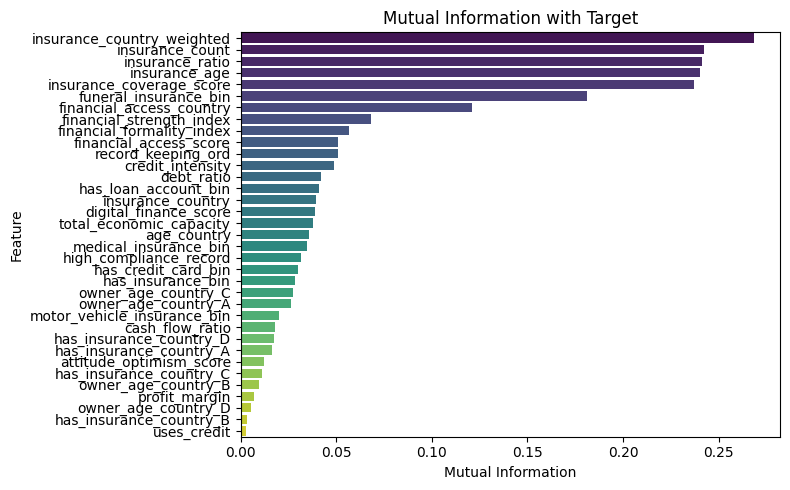

In [185]:

from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import SimpleImputer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



mi_cols = new_cols

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_imputed_array = imputer.fit_transform(X_train[mi_cols])

# Explicitly convert to DataFrame with correct column names
X_imputed = pd.DataFrame(X_imputed_array, columns=mi_cols, index=X_train.index)

# Compute Mutual Information
mi = mutual_info_classif(
    X_imputed,
    y_train,
    discrete_features=False,
    random_state=42
)
print(mi)

# Convert to Series, sort descending
mi_series = pd.Series(mi, index=X_imputed.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(8,5))
sns.barplot(x=mi_series.values, y=mi_series.index, palette='viridis')
plt.title("Mutual Information with Target")
plt.xlabel("Mutual Information")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()




In [186]:
mi_threshold = 0.01
selected_features = mi_series[mi_series > mi_threshold].index.tolist()


# Columns to drop: new_cols that were NOT selected
cols_to_drop = list(set(new_cols) - set(selected_features))

# Drop from X_train and X_test
X_train = X_train.drop(columns=cols_to_drop, errors='ignore')
X_test  = X_test.drop(columns=cols_to_drop, errors='ignore')

print("Dropped columns:", cols_to_drop)
print("New shape X_train:", X_train.shape)
print("New shape X_test:", X_test.shape)

Dropped columns: ['profit_margin', 'uses_credit', 'owner_age_country_D', 'owner_age_country_B', 'has_insurance_country_B']
New shape X_train: (7694, 67)
New shape X_test: (1924, 67)


In [187]:
X_train.to_csv('../data/X_train.csv', index=False)
X_test.to_csv('../data/X_test.csv', index=False)
y_train.to_csv('../data/y_train.csv', index=False)
y_test.to_csv('../data/y_test.csv', index=False)

### Remove Collinear Variables

identifies the highly correlated variables based on the absolute magnitude of the Pearson correlation coefficient being greater than 0.9.

In [3]:
import pandas as pd
import numpy as np

# X is your feature matrix (train set only!)
# IMPORTANT: do this on TRAIN data to avoid leakage
X_corr = X_train.copy()

# Keep only numeric columns
X_corr = X_corr.select_dtypes(include=[np.number])

# Compute correlation matrix
corr_matrix = X_corr.corr().abs()


In [4]:
# Select upper triangle of correlation matrix
upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

# Find feature pairs with correlation > 0.9
high_corr_pairs = [
    (col, row, upper_tri.loc[row, col])
    for col in upper_tri.columns
    for row in upper_tri.index
    if upper_tri.loc[row, col] > 0.9
]

# Convert to DataFrame
high_corr_df = pd.DataFrame(
    high_corr_pairs,
    columns=["Feature_1", "Feature_2", "Abs_Correlation"]
).sort_values(by="Abs_Correlation", ascending=False)

high_corr_df


,Feature_1,Feature_2,Abs_Correlation
13,attitude_satisfied_with_achievement_nan,offers_credit_to_customers_nan,1.000000
66,funeral_insurance_nan,medical_insurance_nan,1.000000
65,has_debit_card_nan,has_internet_banking_nan,1.000000
4,has_cellphone_nan,country_B,1.000000
5,owner_sex_nan,country_B,1.000000
...,...,...,...
44,has_insurance_No,attitude_satisfied_with_achievement_nan,0.910141
43,has_insurance_No,offers_credit_to_customers_nan,0.910141
46,has_insurance_No,keeps_financial_records_nan,0.909349
60,covid_essential_service_nan,motor_vehicle_insurance_Never_had,0.907094


<mark>No logic</mark>

In [15]:
# Features to drop (second feature in each pair)
to_drop = set(high_corr_df["Feature_2"])

print(f"Number of features to drop: {len(to_drop)}")

# Drop from train and test
X_train_reduced = X_train.drop(columns=to_drop)
X_test_reduced = X_test.drop(columns=to_drop)


Number of features to drop: 20


In [16]:
print("Original shape:", X_train.shape)
print("Reduced shape:", X_train_reduced.shape)


Original shape: (7694, 155)
Reduced shape: (7694, 135)


### Recursive Feature Elimination using Random Forest

In [21]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Map target to numeric
y_train_numeric = y_train['Target'].map({'Low': 0, 'Medium': 1, 'High': 2})
y_test_numeric = y_test['Target'].map({'Low': 0, 'Medium': 1, 'High': 2})


rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=5,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

cv = StratifiedKFold(
    n_splits=3,
    shuffle=True,
    random_state=42
)

rfecv = RFECV(
    estimator=rf,
    step=0.1,                 # remove 20% features per iteration
    cv=cv,
    scoring="neg_log_loss",   # multiclass-friendly
    min_features_to_select=10,
    n_jobs=-1,
    verbose=1
)

rfecv.fit(X_train_reduced, y_train_numeric)

print("Optimal number of features:", rfecv.n_features_)


Fitting estimator with 135 features.
Fitting estimator with 135 features.
Fitting estimator with 135 features.
Fitting estimator with 122 features.
Fitting estimator with 122 features.
Fitting estimator with 122 features.
Fitting estimator with 109 features.
Fitting estimator with 109 features.
Fitting estimator with 109 features.
Fitting estimator with 96 features.
Fitting estimator with 96 features.
Fitting estimator with 96 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 83 features.
Fitting estimator with 70 features.
Fitting estimator with 70 features.
Fitting estimator with 70 features.
Fitting estimator with 57 features.
Fitting estimator with 57 features.
Fitting estimator with 57 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 31 features.
Fitting estimator with 31 features.
Fitting estimator with 31 features.
Fitting estimator w

###  Other Options for Dimensionality Reduction


    - PCA: Principle Components Analysis (PCA)
    - ICA: Independent Components Analysis (ICA)
    - Manifold learning: also called non-linear dimensionality reduction


In [26]:
X_train_reduced.to_csv('../data/X_train_fe.csv', index=False)
X_test_reduced.to_csv('../data/X_test_fe.csv', index=False)

While choosing the right model and optimal settings are important, the model can only learn from the data it is given. Making sure this data is as relevant to the task as possible is the job of the data scientist (and maybe some <mark>automated tools</mark> to help us out).


### Polynomial Features



There are X features with individual features raised to powers up to degree 3 and interaction terms. Now, we can see whether any of these new features are correlated with the target.


##### Domain Knowledge Features

#### Aggregating Numeric Columns


False    7694
Name: count, dtype: int64

# Automated feature engineering 

In [6]:
df = pd.read_csv("../fin_health.csv")

In [7]:
import pandas as pd
import featuretools as ft
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, log_loss

# =========================
# 1️⃣ Prepare Data
# =========================
# df contains all features + 'Target'
df = df.reset_index().rename(columns={'index':'id'})  # add unique ID

# Map target to numeric
y = df['Target'].map({'Low': 0, 'Medium': 1, 'High': 2})
X = df.drop(columns=['Target'])

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# =========================
# 2️⃣ Featuretools EntitySet
# =========================
es_train = ft.EntitySet(id='business_data_train')
es_train = es_train.add_dataframe(
    dataframe_name='business',
    dataframe=X_train.assign(Target=y_train.values),  # include target
    index='id'
)

# =========================
# 3️⃣ DFS with numeric interactions
# =========================
feature_matrix_train, feature_defs = ft.dfs(
    entityset=es_train,
    target_dataframe_name='business',
    max_depth=2,
    trans_primitives=['multiply_numeric', 'divide_numeric', 'add_numeric', 'subtract_numeric'],
    agg_primitives=[],  # flat table
    verbose=1
)

# Remove target from features
X_train_ft = feature_matrix_train.drop(columns=['Target'])


Built 143 features
Elapsed: 00:00 | Progress: 100%|██████████


In [17]:
X_train_ft

,country,owner_age,attitude_stable_business_environment,attitude_worried_shutdown,compliance_income_tax,perception_insurance_doesnt_cover_losses,perception_cannot_afford_insurance,personal_income,business_expenses,business_turnover,...,business_expenses - Target,business_expenses - business_turnover,business_expenses - owner_age,business_expenses - personal_income,business_turnover - Target,business_turnover - owner_age,business_turnover - personal_income,owner_age - Target,owner_age - personal_income,personal_income - Target
id,,,,,,,,,,,,,,,,,,,,,
1265,C,27,No,No,No,No,No,40000.0,10000,30000,...,10000.0,-20000.0,9973.0,-30000.0,30000.0,29973.0,-10000.0,27.0,-39973.0,40000.0
5303,B,34,Don’t know or N/A,Don’t know or N/A,No,Don't know,Yes,97.0,300,97,...,300.0,203.0,266.0,203.0,97.0,63.0,0.0,34.0,-63.0,97.0
4512,D,39,Yes,Yes,No,Yes,No,2500.0,4800,288000,...,4799.0,-283200.0,4761.0,2300.0,287999.0,287961.0,285500.0,38.0,-2461.0,2499.0
7452,D,38,No,Yes,No,Don't know,Don't know,500.0,5400,7200,...,5399.0,-1800.0,5362.0,4900.0,7199.0,7162.0,6700.0,37.0,-462.0,499.0
5765,C,36,Don’t know or N/A,No,No,Don't know,Don't know,700000.0,17000,8400000,...,17000.0,-8383000.0,16964.0,-683000.0,8400000.0,8399964.0,7700000.0,36.0,-699964.0,700000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2344,D,27,Yes,Yes,No,Don't know,No,30.0,1080,1800,...,1078.0,-720.0,1053.0,1050.0,1798.0,1773.0,1770.0,25.0,-3.0,28.0
9076,D,52,Yes,No,No,No,Yes,NaN,300,2500,...,300.0,-2200.0,248.0,NaN,2500.0,2448.0,NaN,52.0,NaN,NaN
5343,A,43,No,No,No,No,Yes,600.0,1000,2500,...,998.0,-1500.0,957.0,400.0,2498.0,2457.0,1900.0,41.0,-557.0,598.0


In [9]:

# Apply DFS to test set using same feature_defs
es_test = ft.EntitySet(id='business_data_test')
es_test = es_test.add_dataframe(
    dataframe_name='business',
    dataframe=X_test.assign(Target=y_test.values),
    index='id'
)

feature_matrix_test = ft.calculate_feature_matrix(
    features=feature_defs,
    entityset=es_test
)
X_test_ft = feature_matrix_test.drop(columns=['Target'])


,country,attitude_stable_business_environment,attitude_worried_shutdown,compliance_income_tax,perception_insurance_doesnt_cover_losses,perception_cannot_afford_insurance,motor_vehicle_insurance,has_mobile_money,current_problem_cash_flow,owner_sex,...,perception_insurance_important,covid_essential_service,attitude_more_successful_next_year,has_loan_account,has_internet_banking,has_debit_card,medical_insurance,funeral_insurance,uses_friends_family_savings,uses_informal_lender
id,,,,,,,,,,,,,,,,,,,,,
1265,C,No,No,No,No,No,NaN,Have now,No,Male,...,Yes,NaN,Yes,Never had,Never had,Never had,NaN,NaN,NaN,NaN
5303,B,Don’t know or N/A,Don’t know or N/A,No,Don't know,Yes,Never had,NaN,Yes,NaN,...,NaN,No,Don't know,NaN,NaN,NaN,NaN,NaN,Never had,Never had
4512,D,Yes,Yes,No,Yes,No,Never had,NaN,Yes,Male,...,Yes,Yes,NaN,NaN,NaN,NaN,Never had,Have now,NaN,NaN
7452,D,No,Yes,No,Don't know,Don't know,Never had,NaN,NaN,Female,...,Yes,Yes,NaN,NaN,NaN,NaN,Never had,Have now,NaN,NaN
5765,C,Don’t know or N/A,No,No,Don't know,Don't know,NaN,Have now,No,Male,...,Don?t know / doesn?t apply,NaN,No,Never had,Never had,Used to have but don't have now,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2344,D,Yes,Yes,No,Don't know,No,Never had,NaN,NaN,Female,...,Yes,No,NaN,NaN,NaN,NaN,Never had,Have now,NaN,NaN
9076,D,Yes,No,No,No,Yes,Never had,NaN,NaN,Male,...,Yes,No,NaN,NaN,NaN,NaN,Never had,Never had,NaN,NaN
5343,A,No,No,No,No,Yes,Never had,Have now,0,Female,...,Yes,Don't know,Yes,Have now,Never had,Never had,Never had,Have now,Never had,Never had


In [14]:
X_train_ft.dtypes

country                                 category
owner_age                                  int64
attitude_stable_business_environment    category
attitude_worried_shutdown               category
compliance_income_tax                   category
                                          ...   
business_turnover - owner_age            float64
business_turnover - personal_income      float64
owner_age - Target                       float64
owner_age - personal_income              float64
personal_income - Target                 float64
Length: 142, dtype: object

In [16]:
from sklearn.preprocessing import OneHotEncoder

# Select categorical features
categorical_features = X_train_ft.select_dtypes(include=['object', 'category']).columns.tolist()


# Create encoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

# Fit on train and transform train
X_train_encoded = encoder.fit_transform(X_train_ft[categorical_features])

# Transform test
X_test_encoded = encoder.transform(X_test_ft[categorical_features])

# Convert to DataFrame with proper column names
encoded_cols = encoder.get_feature_names_out(categorical_features)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_cols, index=X_train_ft.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_cols, index=X_test_ft.index)

# Combine with numeric features
numeric_features = X_train_ft.select_dtypes(include=['int64','float64']).columns.tolist()
X_train_encoded = pd.concat([X_train_ft[numeric_features], X_train_encoded_df], axis=1)
X_test_encoded = pd.concat([X_test_ft[numeric_features], X_test_encoded_df], axis=1)

print("X_train shape:", X_train_encoded.shape)
print("X_test shape:", X_test_encoded.shape)


X_train shape: (7694, 242)
X_test shape: (1924, 242)


In [19]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)
y_test_enc  = le.transform(y_test)

In [21]:
import numpy as np

# Check for NaNs
print("NaNs in X_train:", np.isnan(X_train_encoded).sum())
print("NaNs in X_test:", np.isnan(X_test_encoded).sum())

# Check for infinite values
print("Inf in X_train:", np.isinf(X_train_encoded).sum())
print("Inf in X_test:", np.isinf(X_test_encoded).sum())

# Check for extremely large values
print("Max value in X_train:", X_train_encoded.max().max())
print("Max value in X_test:", X_test_encoded.max().max())


NaNs in X_train: owner_age                                                0
personal_income                                         89
business_expenses                                        0
business_turnover                                        0
business_age_years                                       0
                                                        ..
uses_informal_lender_Have now                            0
uses_informal_lender_Never had                           0
uses_informal_lender_Used to have but don't have now     0
uses_informal_lender_Used to have but don’t have now     0
uses_informal_lender_nan                                 0
Length: 242, dtype: Int64
NaNs in X_test: owner_age                                                0
personal_income                                         20
business_expenses                                        0
business_turnover                                        0
business_age_years                                      

In [22]:
X_train_encoded = X_train_encoded.replace([np.inf, -np.inf], np.nan)
X_test_encoded = X_test_encoded.replace([np.inf, -np.inf], np.nan)

from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy='median')
X_train_encoded = pd.DataFrame(imputer.fit_transform(X_train_encoded),
                               columns=X_train_encoded.columns)
X_test_encoded = pd.DataFrame(imputer.transform(X_test_encoded),
                              columns=X_test_encoded.columns)


In [23]:
X_train_encoded = X_train_encoded.clip(-1e10, 1e10)
X_test_encoded = X_test_encoded.clip(-1e10, 1e10)


In [24]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_auc_score, log_loss, accuracy_score
from scipy.stats import randint, uniform
import numpy as np

# Ensure y_train_enc and y_test_enc are integer labels (0, 1, 2, ...)

# -------------------------------
# 1. Hyperparameter search (no change needed here)
# -------------------------------
param_dist = {
    'max_depth': randint(4, 12),
    'learning_rate': uniform(0.01, 0.15),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'min_child_weight': randint(1, 10),
    'gamma': uniform(0.0, 0.5),
    'reg_alpha': uniform(0.0, 0.5),
    'reg_lambda': uniform(0.0, 0.5)
}

xgb_model = xgb.XGBClassifier(
    objective='multi:softprob',
    n_estimators=2000,
    n_jobs=-1,
    random_state=42,
    verbosity=0
)

search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=30,
    cv=5,
    scoring='neg_log_loss',
    refit=True,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

search.fit(X_train_encoded, y_train_enc)

print("Best params:", search.best_params_)
print("Best CV score:", search.best_score_)

# -------------------------------
# 2. Final model with EARLY STOPPING using callbacks
# -------------------------------



# For multi-class: ensure y is label-encoded (0, 1, 2, ..., num_classes-1)
num_classes = len(np.unique(y_train))  # or set manually

model = xgb.XGBClassifier(
    **search.best_params_,
    objective='multi:softprob',     # For multi-class probabilities
    num_class=num_classes,          # Required for multi-class
    eval_metric='mlogloss',         # multi-class logloss
    n_estimators=5000,              # Large number so early stopping can trigger
    random_state=42,
    n_jobs=-1,
    tree_method='hist',             # Faster
    early_stopping_rounds=100       # Set HERE, not in fit()
)

# Now fit — pass eval_set, but NO early_stopping_rounds here
model.fit(
    X_train_encoded, y_train_enc,
    eval_set=[(X_test_encoded, y_test_enc)],
    verbose=50                      # Prints every 50 iterations
)

print(f"Best iteration: {model.best_iteration}")      # 0-based
print(f"Best score: {model.best_score:.5f}")

# Predictions use the best iteration automatically
pred_proba = model.predict_proba(X_test_encoded)
pred_class = model.predict(X_test_encoded)

print("\n--- Test Performance ---")
print(f"ROC AUC (ovr weighted): {roc_auc_score(y_test_enc, pred_proba, multi_class='ovr', average='weighted'):.5f}")
print(f"Log Loss: {log_loss(y_test_enc, pred_proba):.5f}")
print(f"Accuracy: {accuracy_score(y_test_enc, pred_class):.5f}")


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best params: {'colsample_bytree': 0.6036788206466518, 'gamma': 0.05073577143301605, 'learning_rate': 0.10952526536620837, 'max_depth': 8, 'min_child_weight': 2, 'reg_alpha': 0.08040402570874933, 'reg_lambda': 0.27436689468329306, 'subsample': 0.8767580790770773}
Best CV score: -0.001153382032316052
[0]	validation_0-mlogloss:0.94174
[50]	validation_0-mlogloss:0.00353
[100]	validation_0-mlogloss:0.00052
[150]	validation_0-mlogloss:0.00051
[200]	validation_0-mlogloss:0.00051
[215]	validation_0-mlogloss:0.00051
Best iteration: 115
Best score: 0.00051

--- Test Performance ---
ROC AUC (ovr weighted): 1.00000
Log Loss: 0.00051
Accuracy: 1.00000


In [ ]:

# =========================
# 4️⃣ Impute missing values
# =========================
imputer = SimpleImputer(strategy='median')
X_train_imputed = pd.DataFrame(imputer.fit_transform(X_train_ft),
                               columns=X_train_ft.columns, index=X_train_ft.index)
X_test_imputed = pd.DataFrame(imputer.transform(X_test_ft),
                              columns=X_test_ft.columns, index=X_test_ft.index)

# =========================
# 5️⃣ Scale numeric features
# =========================
scaler = MinMaxScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_imputed),
                              columns=X_train_imputed.columns, index=X_train_imputed.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_imputed),
                             columns=X_test_imputed.columns, index=X_test_imputed.index)

# =========================
# 6️⃣ Train Random Forest
# =========================
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# =========================
# 7️⃣ Evaluate
# =========================
y_pred = rf_model.predict(X_test_scaled)
y_pred_proba = rf_model.predict_proba(X_test_scaled)

print("Classification Report:")
print(classification_report(y_test, y_pred))

print("Log Loss:", log_loss(y_test, y_pred_proba))

# =========================
# ✅ X_train_scaled and X_test_scaled now contain original + interaction features
# You can use them for any other model
# =========================


,country,owner_age,attitude_stable_business_environment,attitude_worried_shutdown,compliance_income_tax,perception_insurance_doesnt_cover_losses,perception_cannot_afford_insurance,personal_income,business_expenses,business_turnover,...,has_loan_account,has_internet_banking,has_debit_card,future_risk_theft_stock,business_age_months,medical_insurance,funeral_insurance,motivation_make_more_money,uses_friends_family_savings,uses_informal_lender
id,,,,,,,,,,,,,,,,,,,,,
1265,C,27,No,No,No,No,No,40000.0,10000,30000,...,Never had,Never had,Never had,False,<NA>,NaN,NaN,False,NaN,NaN
5303,B,34,Don’t know or N/A,Don’t know or N/A,No,Don't know,Yes,97.0,300,97,...,NaN,NaN,NaN,<NA>,<NA>,NaN,NaN,False,Never had,Never had
4512,D,39,Yes,Yes,No,Yes,No,2500.0,4800,288000,...,NaN,NaN,NaN,False,0,Never had,Have now,<NA>,NaN,NaN
7452,D,38,No,Yes,No,Don't know,Don't know,500.0,5400,7200,...,NaN,NaN,NaN,True,2,Never had,Have now,<NA>,NaN,NaN
5765,C,36,Don’t know or N/A,No,No,Don't know,Don't know,700000.0,17000,8400000,...,Never had,Never had,Used to have but don't have now,True,<NA>,NaN,NaN,False,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2344,D,27,Yes,Yes,No,Don't know,No,30.0,1080,1800,...,NaN,NaN,NaN,False,11,Never had,Have now,True,NaN,NaN
9076,D,52,Yes,No,No,No,Yes,NaN,300,2500,...,NaN,NaN,NaN,True,8,Never had,Never had,<NA>,NaN,NaN
5343,A,43,No,No,No,No,Yes,600.0,1000,2500,...,Have now,Never had,Never had,<NA>,8,Never had,Have now,<NA>,Never had,Never had


## AutoFeat

In [ ]:
import pandas as pd
from autofeat import AutoFeatClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, log_loss

# 1️⃣ Prepare features and target
X = df.drop(columns=['Target', 'ID', 'id'])
y = df['Target'].map({'Low':0, 'Medium':1, 'High':2})

# 2️⃣ Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 3️⃣ Identify numeric and categorical
num_cols = X_train.select_dtypes(include=['int64','float64']).columns
cat_cols = X_train.select_dtypes(include=['object']).columns

# 4️⃣ Impute missing values
num_imputer = SimpleImputer(strategy='median')
X_train[num_cols] = num_imputer.fit_transform(X_train[num_cols])
X_test[num_cols] = num_imputer.transform(X_test[num_cols])

cat_imputer = SimpleImputer(strategy='most_frequent')
X_train[cat_cols] = cat_imputer.fit_transform(X_train[cat_cols])
X_test[cat_cols] = cat_imputer.transform(X_test[cat_cols])

# 5️⃣ Encode categorical as integers
for col in cat_cols:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])

# 6️⃣ Apply AutoFeat
af_clf = AutoFeatClassifier(verbose=1, feateng_steps=2)
X_train_af = af_clf.fit_transform(X_train, y_train)
X_test_af = af_clf.transform(X_test)




2025-12-27 00:47:55,958 INFO: [AutoFeat] The 2 step feature engineering process could generate up to 33670 features.
2025-12-27 00:47:55,959 INFO: [AutoFeat] With 7694 data points this new feature matrix would use about 1.04 gb of space.
2025-12-27 00:47:55,965 INFO: [feateng] Step 1: transformation of original features


2025-12-27 00:47:58,516 INFO: [feateng] Generated 110 transformed features from 37 original features - done.
2025-12-27 00:47:58,520 INFO: [feateng] Step 2: first combination of features


2025-12-27 00:48:06,529 INFO: [feateng] Generated 10701 feature combinations from 10731 original feature tuples - done.


2025-12-27 00:48:08,668 INFO: [feateng] Generated altogether 10841 new features in 2 steps
2025-12-27 00:48:08,669 INFO: [feateng] Removing correlated features, as well as additions at the highest level
2025-12-27 00:48:19,499 INFO: [feateng] Generated a total of 7782 additional features


[featsel] Scaling data...

2025-12-27 00:48:23,896 INFO: [featsel] Feature selection run 1/5


done.


In [ ]:

# Train a simple classifier on AutoFeat features
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train_transformed, y_train)

# Evaluate
y_pred = rf_model.predict(X_test_transformed)
y_pred_proba = rf_model.predict_proba(X_test_transformed)

print("Classification Report:")
print(classification_report(y_test, y_pred))
print("Log Loss:", log_loss(y_test, y_pred_proba))
